In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import MSTL
from datetime import datetime


# importar librerias 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from datetime import datetime

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time





In [2]:
# abrir datos contugas

new1 = pd.read_excel('EICH106.xlsx')
new1.columns = ['VOLUMEN CORREGIDO', 'STD_VOLUME', 'ORIG_TEMPERATURE', 'TEMPERATURA','PRESION', 'ORIG_PRESSURE', 'VOLUMENSINCORREGIR', 'RAW_VOLUME', 'FECHAINICIAL']

#función que pone las fechas en el mismo formato
def cambiofecha(row):
    
    for i in range(len(row)):
        if isinstance(row.at[i, 'FECHAINICIAL'], str):
            row.at[i, 'FECHAINICIAL'] = pd.to_datetime(row.at[i, 'FECHAINICIAL']).strftime('%Y-%m-%d %H:%M:%S')  
        elif isinstance(row.at[i, 'FECHAINICIAL'], datetime):
            row.at[i, 'FECHAINICIAL'] = datetime.strptime(str(row.at[i, 'FECHAINICIAL']),'%Y-%d-%m %H:%M:%S')
            row.at[i, 'FECHAINICIAL'] = row.at[i, 'FECHAINICIAL'].strftime('%Y-%m-%d %H:%M:%S')

    return row

new1=cambiofecha(new1)

new1 = new1.set_index('FECHAINICIAL')
new1.index = pd.to_datetime(new1.index, format='%Y-%m-%d %H:%M:%S')


# Función que añade al dataframe la hora, dia de la semana, mes y dia del año.
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    #df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    #df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    #df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    return df


new1 = create_features(new1)

datos1=new1[["PRESION", "TEMPERATURA", "VOLUMENSINCORREGIR", "hour", "dayofweek", "month", "dayofyear"]]


#función que elimina las anomalias 

def eliminar_anomalias(df1,Vol,VolMin,VolMax,Temp,TempMin,TempMax,Presion,PresMin,PresMax):

    df=df1.copy()

    if Vol == True:
        df["VOLUMENSINCORREGIR"]= np.where((df["VOLUMENSINCORREGIR"]<VolMin)|(df["VOLUMENSINCORREGIR"]>VolMax),df['VOLUMENSINCORREGIR'].shift(168),df['VOLUMENSINCORREGIR'])

    if Presion == True:
        df["PRESION"]= np.where((df["PRESION"]<PresMin)|(df["PRESION"]>PresMax),df['PRESION'].shift(168),df['PRESION'])

    if Temp == True:
        df["TEMPERATURA"]= np.where((df["TEMPERATURA"]<TempMin)|(df["TEMPERATURA"]>TempMax),df['TEMPERATURA'].shift(168),df['TEMPERATURA'])


    return df



datos1=eliminar_anomalias(datos1,   True,0,250,True,17,35,True,14,19) ## Falta Presion

In [3]:
datos1

,PRESION,TEMPERATURA,VOLUMENSINCORREGIR,hour,dayofweek,month,dayofyear
FECHAINICIAL,,,,,,,
2018-10-24 10:00:00,17.812536,23.294756,0.000,10,2,10,297
2018-10-24 11:00:00,17.785923,24.879368,48.687,11,2,10,297
2018-10-24 12:00:00,17.849327,25.593176,25.125,12,2,10,297
2018-10-24 13:00:00,17.783957,24.487469,3.563,13,2,10,297
2018-10-24 14:00:00,17.840059,24.522886,3.312,14,2,10,297
...,...,...,...,...,...,...,...
2024-01-25 06:00:00,17.368910,27.570827,0.000,6,3,1,25
2024-01-25 07:00:00,17.370106,27.505213,0.000,7,3,1,25
2024-01-25 08:00:00,17.403006,27.323944,0.000,8,3,1,25


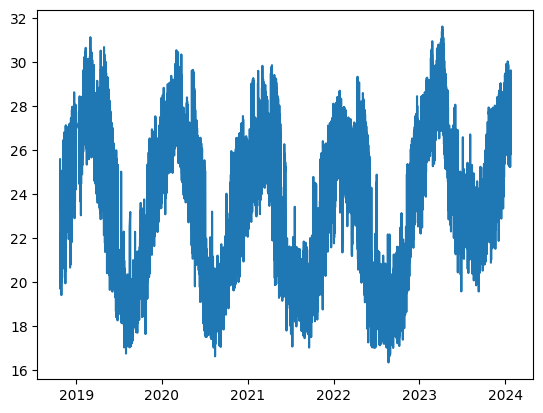

In [4]:
plt.plot(datos1['TEMPERATURA'])

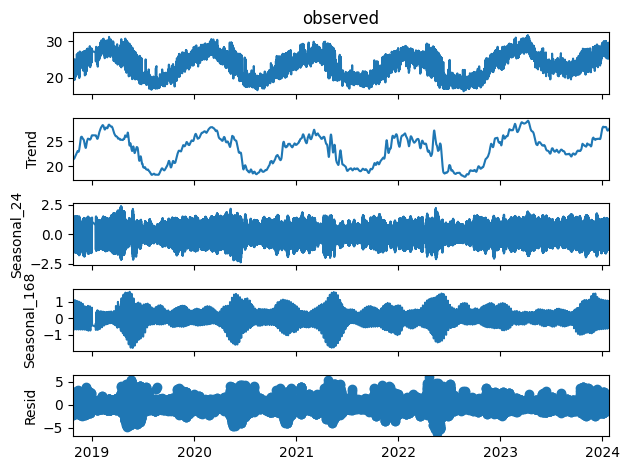

In [5]:
mstl = MSTL(datos1['TEMPERATURA'], periods=[24, 24 * 7], iterate=5, stl_kwargs={"seasonal_deg": 0,
                                                                          "inner_iter": 2,
                                                                          "outer_iter": 0})
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()







In [6]:
res.trend

tendencia = res.trend
seasonal = res.seasonal
residual = res.resid


In [7]:
Datos = tendencia + seasonal['seasonal_168'] + seasonal['seasonal_24'] + residual

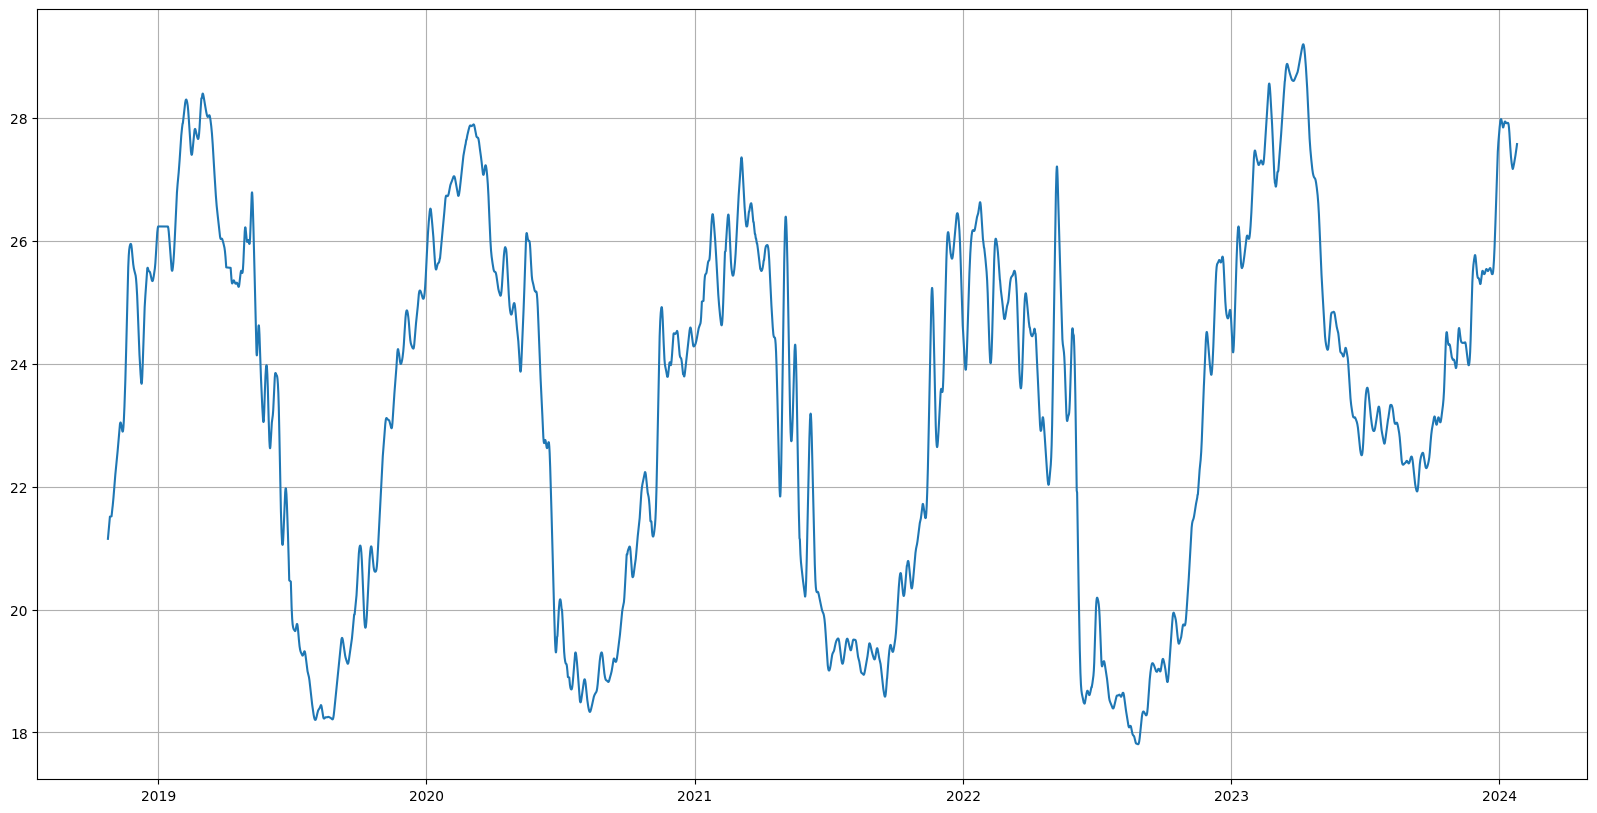

In [8]:
plt.figure(figsize=(20,10))
plt.plot(tendencia)
plt.grid()


In [9]:
tendenciaFourier = np.fft.fft(tendencia)

# Generar el ruido Laplaciano y aplicarlo a los coeficientes de Fourier
b = 100
deltaf = 1
epsilon = deltaf/ b

# loc = media, scale = b
laplace = np.random.laplace(loc=0, scale=1/epsilon,size = tendenciaFourier.shape )

#laplace_noise = np.random.laplace(loc=0, scale=b, size=tendenciaFourier.shape)
perturbed_trend_dft = tendenciaFourier + laplace


# 
perturbed_trend = np.fft.ifft(perturbed_trend_dft).real


# sacar datos de ruido
DatosRuido = perturbed_trend + seasonal['seasonal_168'] + seasonal['seasonal_24'] + residual

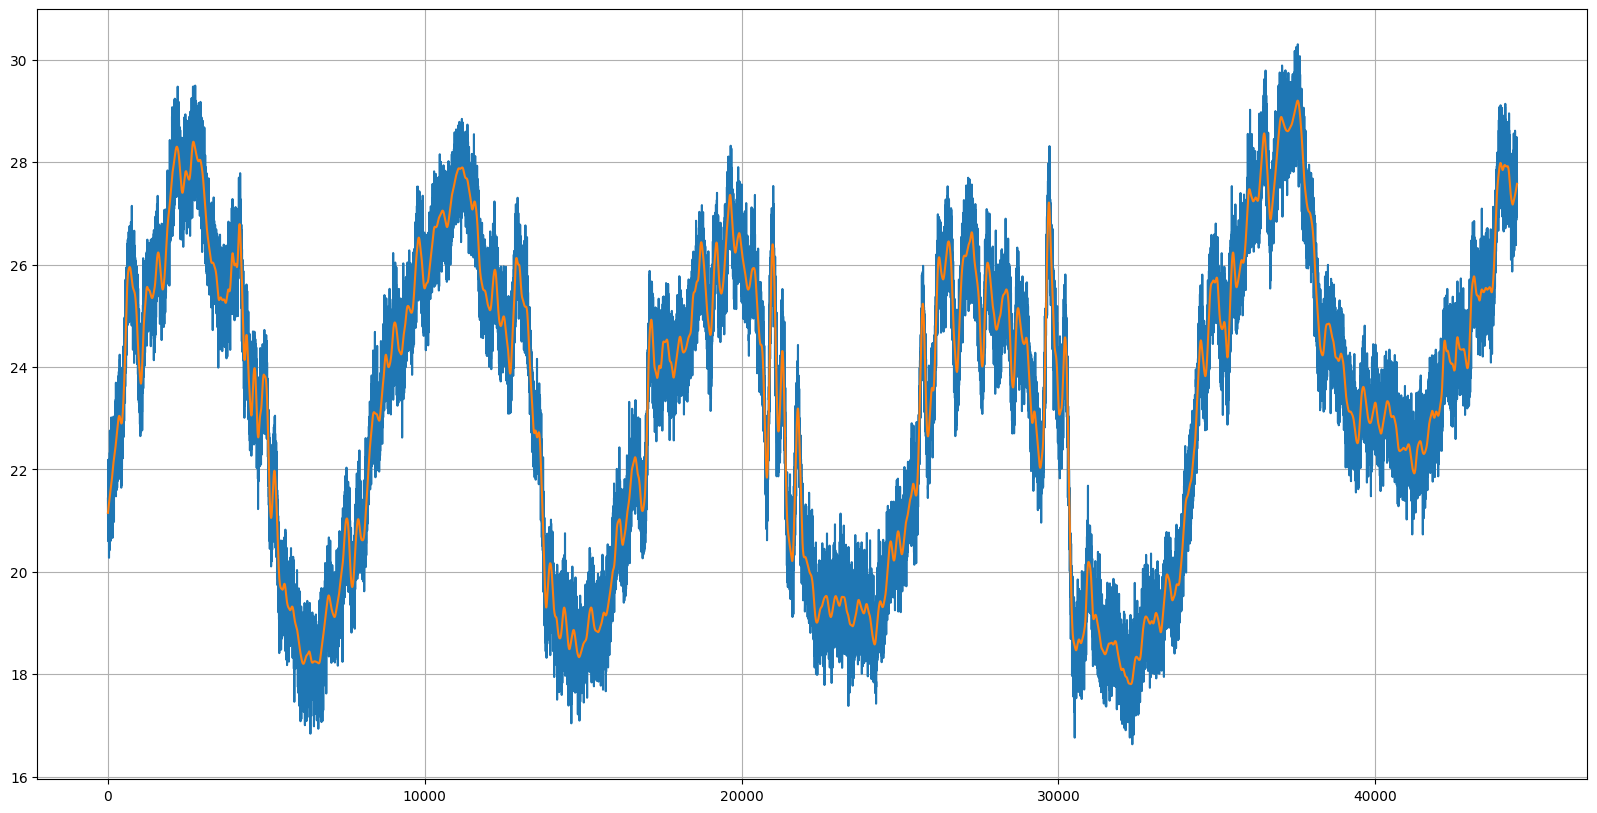

In [10]:
plt.figure(figsize=(20,10))
plt.plot(perturbed_trend[:])
plt.plot(tendencia.values[:])
plt.grid()


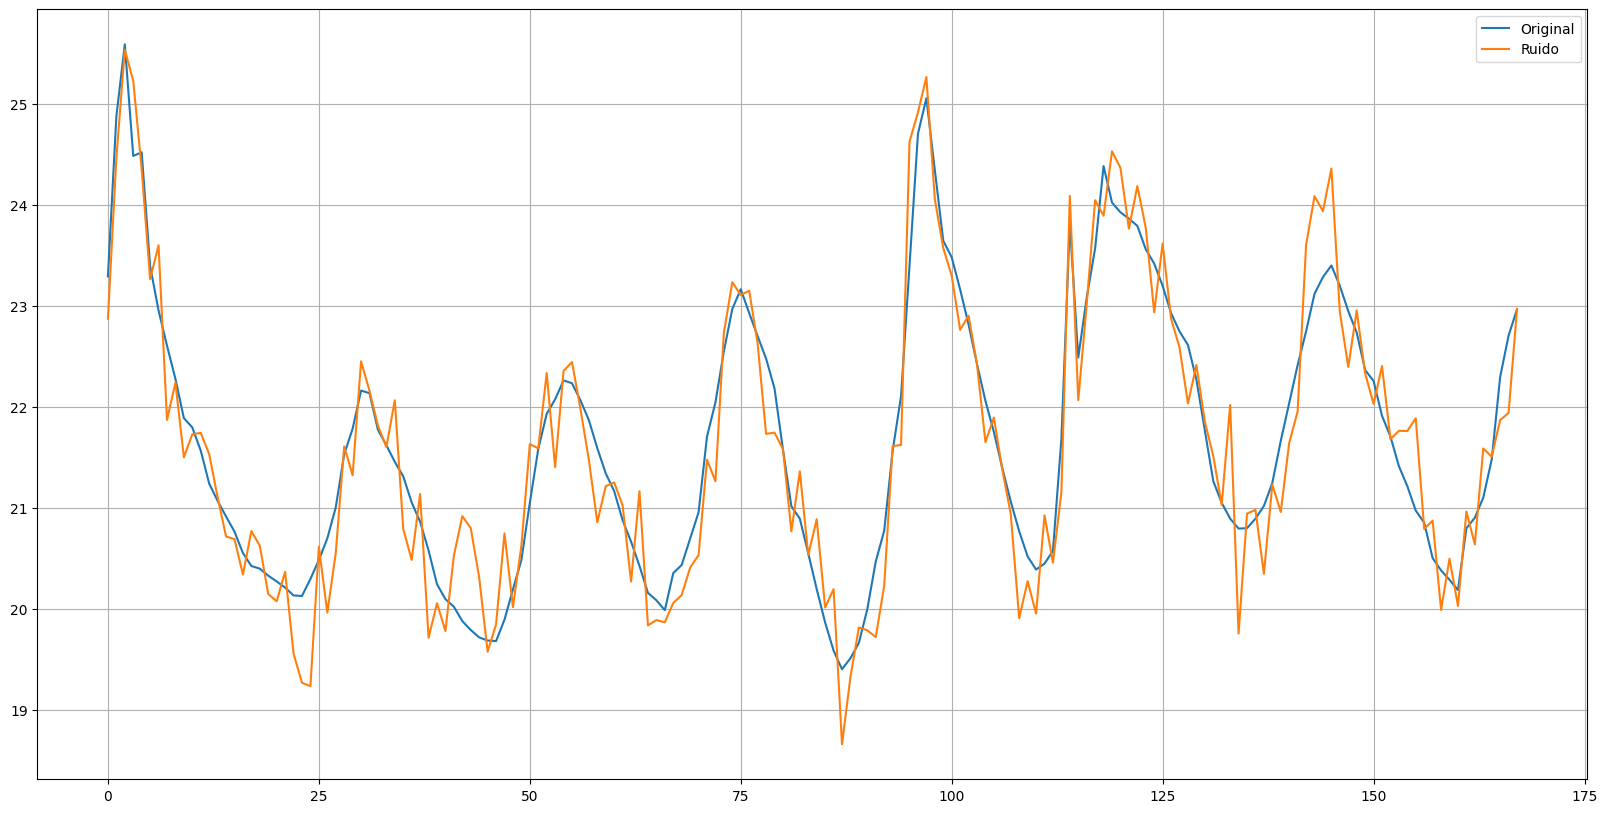

In [30]:
plt.figure(figsize=(20,10))
plt.plot(datos1['TEMPERATURA'][:168].values,label = "Original")
plt.plot(DatosRuido.values[:168],label = "Ruido")
plt.legend()
plt.grid()

In [12]:
# crear función 

def STL_DP(datos,deltaf_p,b_p):

    mstl = MSTL(datos, periods=[24, 24 * 7], iterate=5, stl_kwargs={"seasonal_deg": 0,
                                                                            "inner_iter": 2,
                                                                            "outer_iter": 0})
    res = mstl.fit() # Use .fit() to perform and return the decomposition
    #ax = res.plot()
    #plt.tight_layout()


    res.trend

    tendencia = res.trend
    seasonal = res.seasonal
    residual = res.resid


    tendenciaFourier = np.fft.fft(tendencia)

    # Generar el ruido Laplaciano y aplicarlo a los coeficientes de Fourier
    b = b_p
    deltaf = deltaf_p
    epsilon = deltaf/ b

    # loc = media, scale = b
    laplace = np.random.laplace(loc=0, scale=1/epsilon,size = tendenciaFourier.shape )

    #laplace_noise = np.random.laplace(loc=0, scale=b, size=tendenciaFourier.shape)
    perturbed_trend_dft = tendenciaFourier + laplace


    # 
    perturbed_trend = np.fft.ifft(perturbed_trend_dft).real


    # sacar datos de ruido
    DatosRuido = perturbed_trend + seasonal['seasonal_168'] + seasonal['seasonal_24'] + residual



    return DatosRuido,epsilon

In [25]:
# Datos, DeltaF, B
DatosRuido,epsilon = STL_DP(datos1['TEMPERATURA'],1,100)

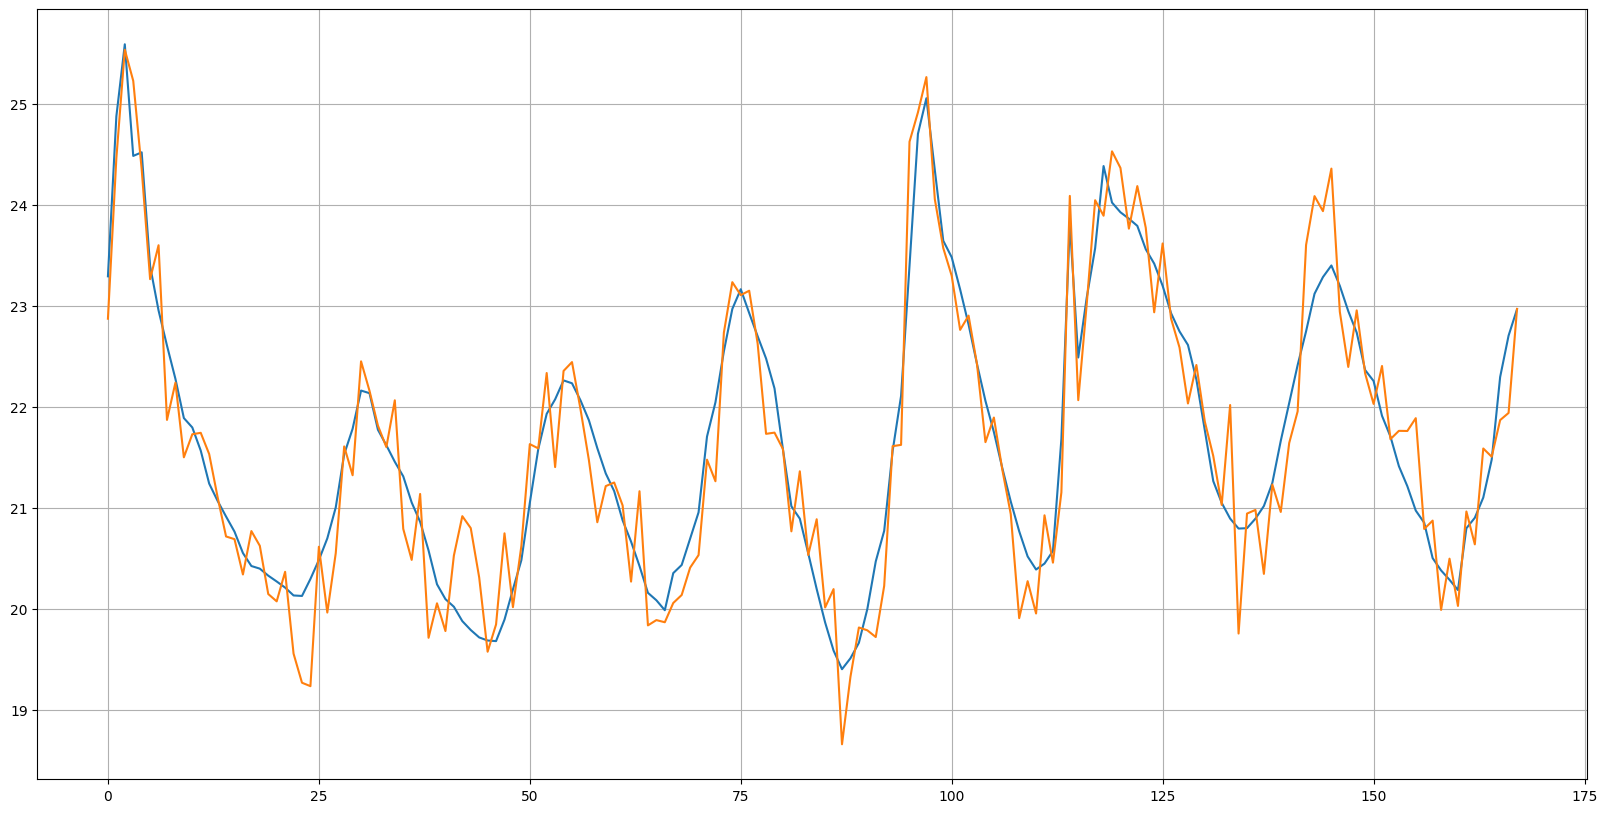

In [29]:
plt.figure(figsize=(20,10))
plt.plot(datos1['TEMPERATURA'][:168].values)
plt.plot(DatosRuido.values[:168])
plt.grid()

# Demostración
$Pr[M(x) \in S] \leq e^{k  \epsilon} Pr[M(y) \in S] $


Definición: A randomized algorithm M with domain $ \mathbb{N}^{|X|}$ is $(\epsilon, \delta)$ - differentially private if for all S $\subseteq$  Range(M) and for all $x,y \in \mathbb{N}^{|X|} $ such that $||x-y||_1 \leq 1$



En otras palabras más sencillas:

A process A is $ \epsilon $  -differentially private if for all databases D1 and D2 which differ in only one individual:

$ P[A(D_1) = O] \leq e^{\epsilon} P[A(D_2) =O] $

donde: $ P[A(D_1) = O]$ es la probabilidad de que cuando corra el algoritmo A, o mecanismo M. en el dataset $D_1$, el resultado sea O, o que el resultado esté en el conjunto S

$e^{\epsilon}$ es la función exponencial que se aplica a $\epsilon$ entre más cerca $\epsilon $ esté a 0, entonces $e^{\epsilon}$ estará más cerca a 1, y las probabilidades deben ser parecidas. entrem más grande sea epsilon, más diferentes van a ser las probabilidades



In [32]:
2/10

0.2

In [33]:
1/9

0.1111111111111111

### ¿ por qué cuando epsilon es pequeño, las probabilidades deben ser más parecidas?

### posible solución. 

Definir S, como el conjunto de posibles resultados (que caigan dentro de un rango los valores) (se me ocurre que sean +- el valor original)

Ejecutar el mecanismo STL_DP varias veces para $D_1$ y para $D_2$

guardar los resultados.

la probabilidad será entonces: $Pr[M(x) \in S] $  = $ \frac{Exitos}{Intentos}  $


In [15]:
# definir D1 y D2

D1 = datos1

D2 = datos1.iloc[1:,:]




In [36]:
t_min = D1['TEMPERATURA'].min() 
t_max = D1['TEMPERATURA'].max() 


In [37]:
def CalcularProbabilidades(datos,datos2,S_min,S_Max,num_simu,deltaf,b):
    exitosD1 = 0
    exitosD2 = 0

    for i in range(num_simu):
        DatosRuidoD1,epsilon = STL_DP(datos,deltaf,b)
        DatosRuidoD2,epsilon = STL_DP(datos2,deltaf,b)

        if np.all((DatosRuidoD1 >= S_min) & (DatosRuidoD1 <= S_Max)):
            exitosD1 = exitosD1 +1

        if np.all((DatosRuidoD2 >= S_min) & (DatosRuidoD2 <= S_Max)):
            exitosD2 = exitosD2 +1


    p_D1 = exitosD1 / num_simu
    p_D2 = exitosD2 / num_simu

    return p_D1,p_D2,epsilon




In [38]:
P_D1,P_D2,epsilon = CalcularProbabilidades(D1['TEMPERATURA'],D2['TEMPERATURA'],t_min,t_max,10,1,100)



In [40]:
P_D1 <= np.exp(epsilon)* P_D2

True

In [42]:
P_D2

0.0

In [ ]:
# Probabilidad de que cuando me devuelvo la observación esté en un intervalo. 


